In [5]:
import os
import numpy as np
import pandas as pd
from nilearn import plotting
import scipy
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import matplotlib.pyplot as plt
#from connUtils import removeVars, timeSeriesSingle, createCorMat

In [7]:

# fetch atlas
atlas=datasets.fetch_atlas_difumo(dimension=256, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
#atlas = datasets.fetch_atlas_msdl()  #previous atlas
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]


# Loading atlas data stored in 'labels'

labels = atlas["labels"]


print("Atlas file path:", atlas_filename)


Atlas file path: /home/ptslab/nilearn_data/difumo_atlases/256/2mm/maps.nii.gz


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0016078941989690065. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:378: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.001523372484371066. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float v

/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0018470935756340623. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.001526794396340847. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0013393814442679286. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.0013245478039607406. But, you have given threshold=0.6 
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilear

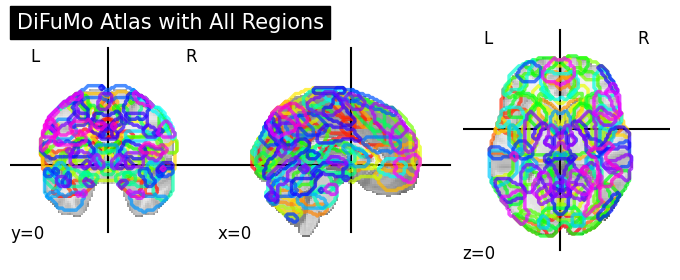

In [8]:
# Plot the atlas with all regions
plotting.plot_prob_atlas(
    atlas_filename,
    title="DiFuMo Atlas with All Regions",
    display_mode="ortho",  # Orthogonal view (coronal, sagittal, axial)
    cut_coords=(0, 0, 0),  # Coordinates for cross-section
    threshold=0.6,  # Show regions above a certain probability
)
plotting.show()

In [9]:
# Initialize the masker
masker = NiftiMapsMasker(
    maps_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=0, #1 if you want basic progress information
    tr=2.5
)

In [10]:
# Prepare an empty array to store the correlation matrices (shape: (76 subjects, 256 regions, 256 regions))
cor_mat_array_76 = np.full((77, 256, 256), np.nan)

In [11]:
#subject_idx = 0  # Index for storing results in cor_mat_array_76
excluded_subjects = []  # List to store the IDs of excluded subjects
for subject_id in range(1, 77):
    # Define the paths to the functional and confound files
    func_file = f'/home/ptslab/Pain_Data/preproc/sub-{subject_id:02d}/func/sub-{subject_id:02d}_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
    confound_file = f'/home/ptslab/Pain_Data/preproc/sub-{subject_id:02d}/func/sub-{subject_id:02d}_task-rest_desc-confounds_timeseries.tsv'
    
    # Load the confound file
    confound = pd.read_csv(confound_file, sep="\t", na_values="n/a")
     # Check if framewise displacement (FD) > 0.6 for any frame; if yes, skip the subject
    fd = confound['framewise_displacement']
    if fd.mean() > 0.6:  # If avg FD exceeds 0.6, skip this subject
        cor_mat_array_76[subject_id, :, :] = np.nan #put nan in all values of subjects with FD>0.6
        excluded_subjects.append(subject_id) 
        print(f"Skipping subject {subject_id} due to FD > 0.6")
        
        continue

      # Select relevant columns and fill missing values with 0
    finalConf = confound[['csf', 'white_matter', 'framewise_displacement',
                          'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04',
                          'a_comp_cor_05', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']]
    finalConf = finalConf.fillna(0)
    
    # Preprocess the functional file and extract the time series
    time_series = masker.fit_transform(func_file, confounds=finalConf)
    
    # Remove the first 5 frames from the time series
    time_series = time_series[5:]
    
    # Create a ConnectivityMeasure object to compute correlation
    correlation_measure = ConnectivityMeasure(kind='correlation')
    
    # Compute the correlation matrix
    cor_mat = correlation_measure.fit_transform([time_series])[0]
    
    # Store the correlation matrix in the array
    cor_mat_array_76[subject_id, :, :] = cor_mat
    #subject_idx += 1
    


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:243: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores

Skipping subject 35 due to FD > 0.6


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead

Skipping subject 44 due to FD > 0.6


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead

Skipping subject 56 due to FD > 0.6


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead

Skipping subject 71 due to FD > 0.6
Skipping subject 72 due to FD > 0.6


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [
/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead

Skipping subject 76 due to FD > 0.6


/home/ptslab/miniconda3/envs/analysis/lib/python3.10/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


In [16]:
file_name = 'Timeseries.npy' 
np.save(file_name, time_series, allow_pickle=True, fix_imports=True)

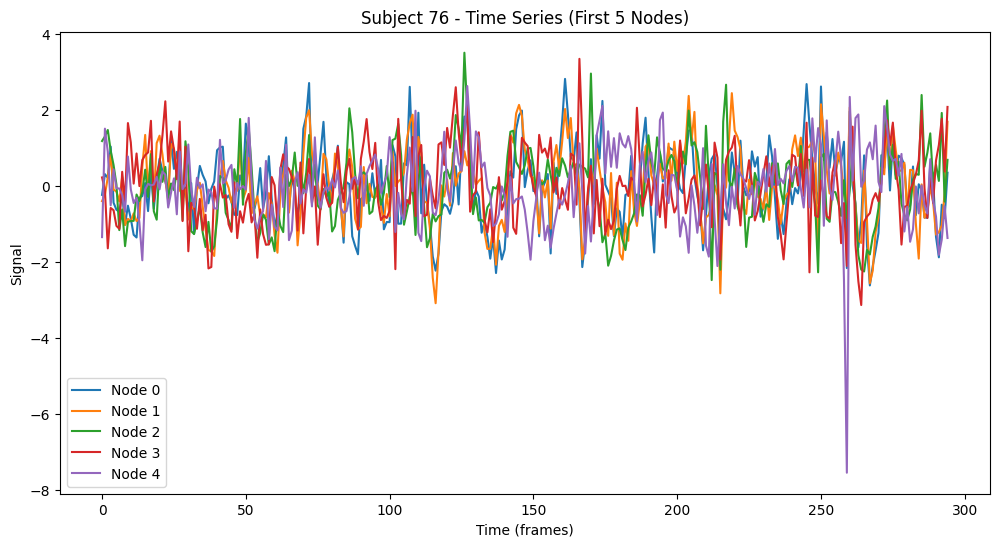

In [17]:
# plot time series of 5 first ROIs for sanity check
  
plt.figure(figsize=(12, 6))
for node in range(min(5, time_series.shape[1])):  # Plot first 5 nodes
    plt.plot(time_series[:, node], label=f'Node {node}')
plt.title(f'Subject {subject_id} - Time Series (First 5 Nodes)')
plt.xlabel('Time (frames)')
plt.ylabel('Signal')
plt.legend()
plt.show()

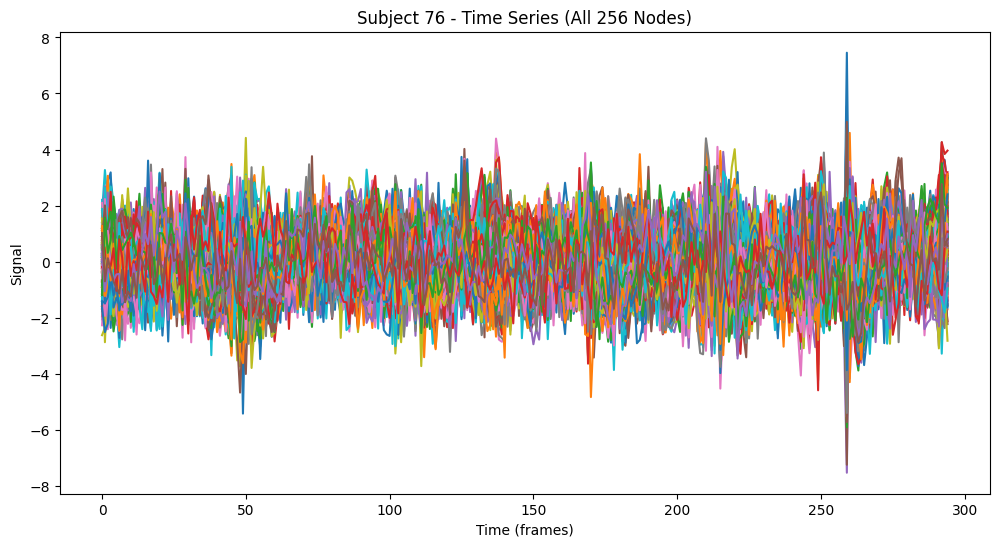

In [22]:
# plot time series of all ROIs
time_series=np.load('Timeseries.npy')  
plt.figure(figsize=(12, 6))
for node in range(time_series.shape[1]):  # Plot all nodes
    plt.plot(time_series[:, node], label=f'Node {node}')
plt.title(f'Subject {subject_id} - Time Series (All 256 Nodes)')
plt.xlabel('Time (frames)')
plt.ylabel('Signal')
#plt.legend()
plt.show()

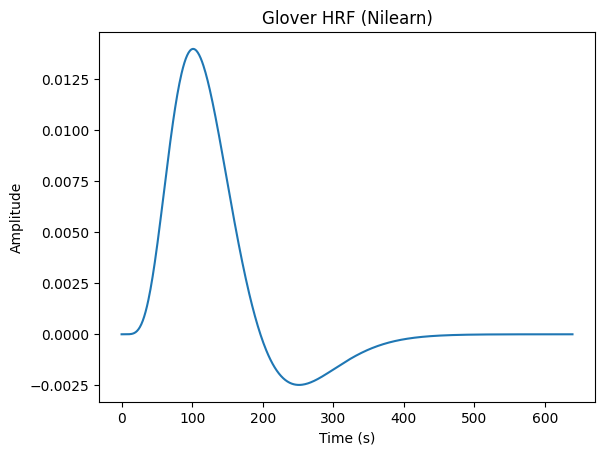

In [ ]:
# Plot Nilearn's HRF function
from nilearn.glm.first_level import glover_hrf
# Generate the HRF
tr=2.5
hrf = glover_hrf(tr)
plt.plot(hrf)
plt.title("Glover HRF (Nilearn)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

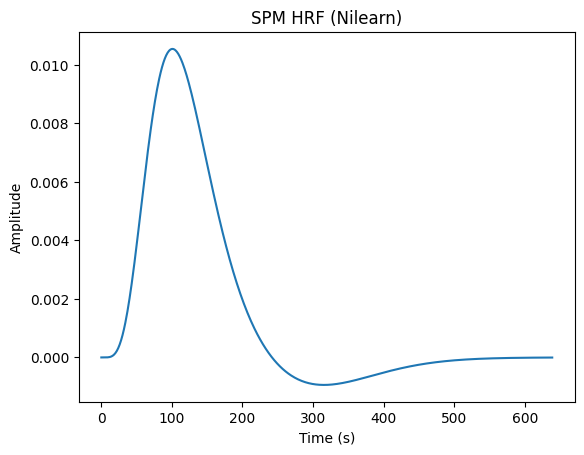

In [4]:
# Plot another HRF function
from nilearn.glm.first_level import spm_hrf
tr=2.5
# Generate SPM HRF
spm_hrf_curve = spm_hrf(tr)

# Plot SPM HRF
plt.plot(spm_hrf_curve)
plt.title("SPM HRF (Nilearn)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
# Plot one node time series and its convolution with HRF -----------

In [ ]:
'''
import pickle

# Save the array to a pickle file
with open("cor_mat_array_76.pkl", "wb") as f:
    pickle.dump( cor_mat_array_76, f)
'''

In [3]:

import pickle
with open("cor_mat_array_76.pkl", "rb") as f:
    cor_mat_array_76 = pickle.load(f)

# print(cor_mat_array_76)


In [9]:
# Save list of excluded to a txt file:
output_txt_path= r'/home/ptslab/Pain_Data/OpenNeuro_pain_Data/excluded_subjects'
excluded_df = pd.DataFrame({'Excluded_Subjects': excluded_subjects})
excluded_df.to_csv(output_txt_path, index=False, sep="\t")  # Use tab-separated values for clarity

NameError: name 'excluded_subjects' is not defined

In [2]:
'''
# option to save to numpy
output_file = "/home/ptslab/Pain_Data/cor_mat_array_76_data.npy"
np.save(output_file, cor_mat_array_76)

print (cor_mat_array_76)
'''

'\n# option to save to numpy\noutput_file = "/home/ptslab/Pain_Data/cor_mat_array_76_data.npy"\nnp.save(output_file, cor_mat_array_76)\n\nprint (cor_mat_array_76)\n'

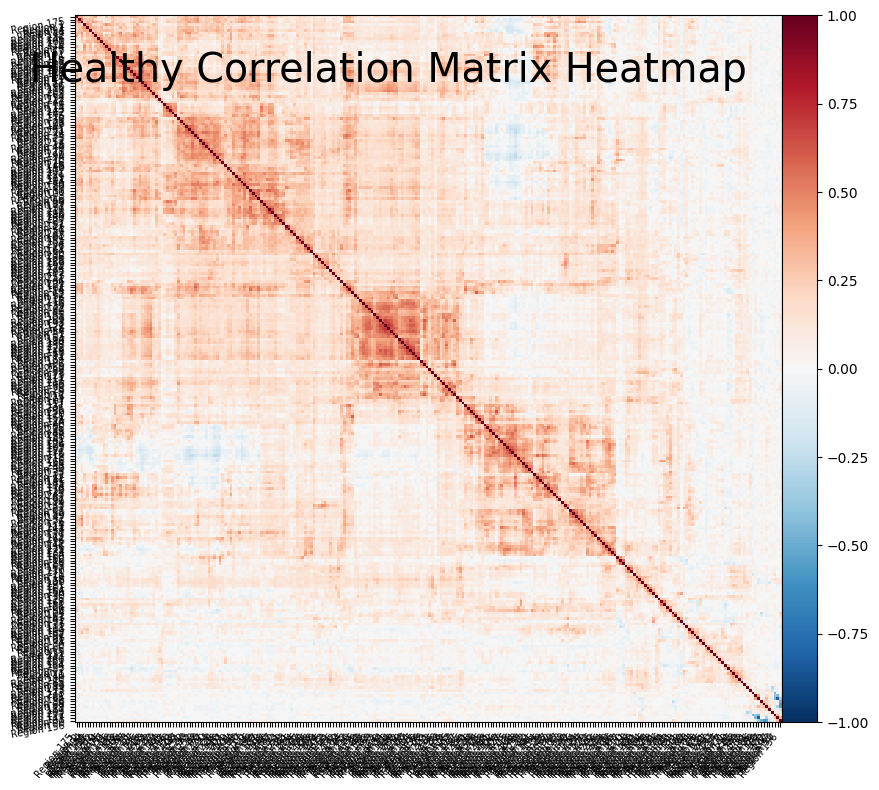

In [65]:
from nilearn import plotting

#cor_mat_array_76_no_na= np.nanmean(cor_mat_array_76)
healthy_mean_matrix = np.nanmean(cor_mat_array_76[1:20,:,:], axis=0)  # Resulting shape: (256, 256)
pain_mean_matrix = np.nanmean(cor_mat_array_76[21:76,:,:], axis=0)


# Step 2: Define brain region labels (Replace with actual labels from your atlas)
labels = [f"Region {i+1}" for i in range(256)]  # Example labels

# Step 3: Use Nilearn's plotting function to plot the heatmap
plotting.plot_matrix(
    healthy_mean_matrix,
    figure=(10, 8),           # Figure size
    labels=labels,            # Brain region labels
    auto_fit=True,            # Automatically adjust label positioning
    reorder=True,             # Reorder matrix for clustering
    colorbar=True,            # Include a colorbar
    vmax=1,                   # Maximum value for color range
    vmin=-1,                  # Minimum value for color range
    title="Healthy Correlation Matrix Heatmap"
)

# Display the plot
plotting.show()



In [66]:
np.savetxt("matrix_3d.txt", cor_mat_array_76.reshape(-1, cor_mat_array_76.shape[1]))

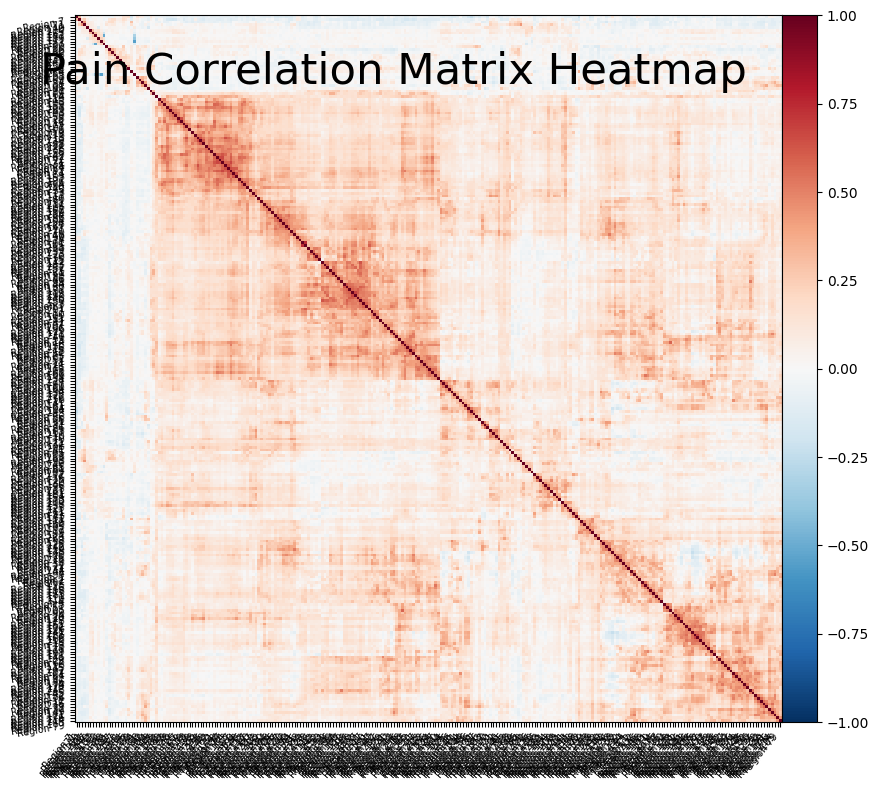

In [67]:
plotting.plot_matrix(
    pain_mean_matrix,
    figure=(10, 8),           # Figure size
    labels=labels,            # Brain region labels
    auto_fit=True,            # Automatically adjust label positioning
    reorder=True,             # Reorder matrix for clustering
    colorbar=True,            # Include a colorbar
    vmax=1,                   # Maximum value for color range
    vmin=-1,                  # Minimum value for color range
    title="Pain Correlation Matrix Heatmap"
)

plotting.show()

In [ ]:
#This is a test update